# Developing the workflow for using the the AOP modeling for a target

Needed to create and index PUBCHEM AID_PUBCHEM OUTCOME_PUBCHEM CID

First get assays associated with a target

In [92]:
import config
import pandas as pd

TARGET = 'ESR1'

# get assays that belong to a particular
# target
query = 'SELECT tG.PUBCHEM_AID, tG.GeneSymbol ' \
        'FROM targets tG ' \
        'WHERE GeneSymbol == "{}"' \
        ''.format(TARGET)

genes_aids = pd.read_sql_query(query, con=config.Config.DB_URI)

print(genes_aids)

    PUBCHEM_AID GeneSymbol
0           713       ESR1
1           737       ESR1
2          1078       ESR1
3          1079       ESR1
4          1223       ESR1
5        588513       ESR1
6        588514       ESR1
7        743069       ESR1
8        743075       ESR1
9        743079       ESR1
10       743080       ESR1
11      1259244       ESR1
12      1259383       ESR1


Then just get compounds that are identified as "active" for modeling


In [93]:
aid_list = [str(aid)for aid in genes_aids.PUBCHEM_AID]

aid_string = ", ".join(map(str, aid_list))
aid_query = f'({aid_string})'

actives_query = 'SELECT c.PUBCHEM_CID as CID, c.PUBCHEM_AID as AID, c.PUBCHEM_SID as SID ' \
                'FROM concise c ' \
                'WHERE c.PUBCHEM_AID in {} AND c.PUBCHEM_ACTIVITY_OUTCOME == "Active" AND ' \
                'c.PUBCHEM_CID is not null AND c.PUBCHEM_SID is not null'.format(aid_query)

active_cmps = pd.read_sql_query(actives_query, con=config.Config.DB_URI)
active_cmps['SID'] = active_cmps['SID'].astype(int)

print(active_cmps.shape)

(3918, 3)


Now get the corresponding dose responses

In [94]:
sid_list = [str(sid)for sid in active_cmps.SID]

sid_string = ", ".join(map(str, sid_list))
sid_query = f'({sid_string})'

dr_query = 'SELECT  SID, AID, concentration as conc, response as resp ' \
                'FROM dose_response ' \
                'WHERE AID in {} AND SID in {} '.format(aid_query, sid_query)

dose_responses = pd.read_sql_query(dr_query, con=config.Config.DB_URI)

print(dose_responses.head())

      SID  AID    conc    resp
0  842142  713  1.5625   1.160
1  842142  713  1.5625  83.107
2  842142  713  3.1250   1.040
3  842142  713  3.1250  66.953
4  842142  713  6.2500   1.130


Merge with the actives dataframe to get cids back

In [95]:
# this merge is necessary because
# the former query gathers all data
# for all sid and aid that have any active cmps
# not just the pairs of active sid, aid
dr_merged = pd.merge(dose_responses, active_cmps[['SID', 'CID', 'AID']].drop_duplicates(['SID', 'CID', 'AID']), on=['SID', 'AID'])
print(dr_merged.head())

      SID  AID    conc    resp      CID
0  842142  713  1.5625   1.160  5770444
1  842142  713  1.5625  83.107  5770444
2  842142  713  3.1250   1.040  5770444
3  842142  713  3.1250  66.953  5770444
4  842142  713  6.2500   1.130  5770444


Some sanity checks....count the number of AIDs that a CID is tested in...

In [96]:
counts = (
          dr_merged
          .groupby('CID')
          ['AID'].nunique()
          .sort_values(ascending=False)
          )
print(counts.head())

CID
73864      8
5281576    8
657220     7
11742      6
448537     6
Name: AID, dtype: int64


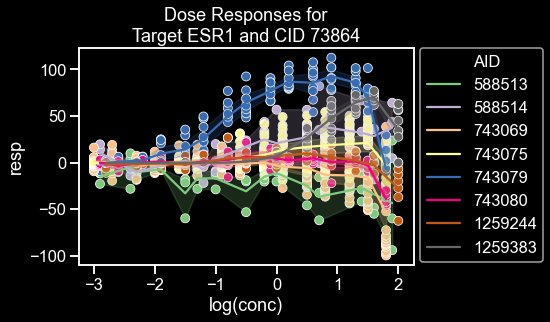

In [97]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")


dr_merged.loc[:, 'log(conc)'] = np.log10(dr_merged['conc'])

# some concentrations are too precision
# so rounding can help
dr_merged.loc[:, 'log(conc)'] = dr_merged['log(conc)'].round(1)

dr_merged.loc[:, 'AID']  = dr_merged['AID'].astype("category")

grouped_by_cid = dr_merged.groupby('CID')

cid = counts.index[0]


data = grouped_by_cid.get_group(cid)

sns.scatterplot(data=data, x='log(conc)', y='resp', hue='AID', legend=False,  palette='Accent')
sns.lineplot(data=data, x='log(conc)', y='resp', hue='AID',  palette='Accent')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.title(f"Dose Responses for\nTarget {TARGET} and CID {cid}")

plt.show()

In [98]:
data.AID.unique()

[588513, 588514, 743075, 743079, 1259383, 743069, 743080, 1259244]
Categories (8, int64): [588513, 588514, 743075, 743079, 1259383, 743069, 743080, 1259244]

Text(0.5, 1.0, 'Avg. Dose Responses for\nTarget ESR1 and CID 73864')

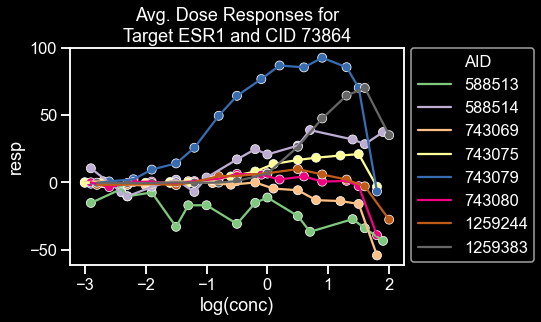

In [99]:

# NEED TO FIGURE OUT WHY I NEED
# TO DROP NA HERE!!!!!
# edit: think it might be due to categorical axis....
response_avg = data.groupby(['AID', 'log(conc)'])['resp'].mean().reset_index().dropna()

#response_avg.loc[response_avg.resp <= 0, 'resp'] = 0

sns.scatterplot(data=response_avg, x='log(conc)', y='resp', hue='AID', legend=False, palette='Accent')
sns.lineplot(data=response_avg, x='log(conc)', y='resp', hue='AID', palette='Accent')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f"Avg. Dose Responses for\nTarget {TARGET} and CID {cid}")

Use curveP to "fix curves"

In [100]:
from curvep import curveP
response_avg['AID'] = response_avg['AID'].astype(str)

response_avg_corrected = response_avg.groupby('AID').apply(curveP).reset_index(drop=True)
response_avg_corrected.head()

,AID,log(conc),resp
0,1259244,-2.8,0.0
1,1259244,-2.3,0.0
2,1259244,-1.9,0.0
3,1259244,-1.5,0.0
4,1259244,-1.2,0.0


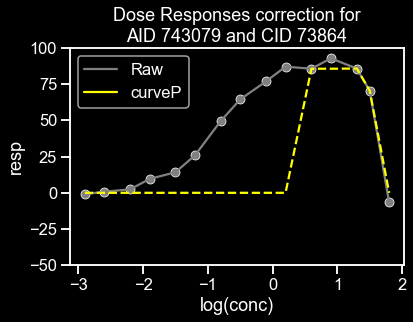

In [137]:
aid = 588514
aid = 1259383
aid = 588513
aid = 743079

data_one = response_avg.query(f"AID == '{aid}'")
data_one_r = response_avg_corrected.query(f"AID == '{aid}'")

sns.scatterplot(data=data_one, x='log(conc)', y='resp', color='grey')
sns.lineplot(data=data_one, x='log(conc)', y='resp', color='grey', label='Raw')

ax = sns.lineplot(data=data_one_r, x='log(conc)', y='resp', ls='--', color='yellow', label='curveP')


# Might need to loop through the list if there are multiple lines on the plot
ax.lines[1].set_linestyle("--")

plt.ylim(-50, 100)

plt.title(f"Dose Responses correction for\nAID {aid} and CID {cid}")

plt.show()